## Read about the dataset
https://www.kaggle.com/competitions/playground-series-s5e5/overview

In [1]:
%load_ext cuml.accel
%load_ext cudf.pandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


cuML: Accelerator installed.


Because our data is large and the csv file is a bit slow for this task, we will convert the data to parquet format.

In [2]:
#-----------------------------------------------------
## convert to parquet
# Path to the initial CSV file
csv_path = "train.csv"
# Parquet output path
parquet_path = "train.parquet"

# One-time: Convert CSV to Parquet
gdf_initial = pd.read_csv(csv_path)
gdf_initial.to_parquet(parquet_path, compression="snappy")
#-----------------------------------------------------

In [3]:
data = pd.read_parquet('train.parquet')
df =pd.DataFrame(data)
original_df = df.copy()
df = df.drop(columns=['id'] , axis=1)
df = df.reset_index(drop=True)
print( 'Data frame dimensions: ',df.shape)
df.head(3)

Data frame dimensions:  (750000, 8)


,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,female,51,161.0,64.0,7.0,84.0,39.8,29.0


## Data Cleaning

In [4]:
missing_data = df.isna().sum()
missing_data = missing_data[missing_data > 0]
missing_data

Series([], dtype: int64)

In [5]:
# Checking if all values in each column are the same
columns_with_same_values = []

for col in df.columns:
    first_value = df[col].iloc[0]
    if df[col].eq(first_value).all():
        columns_with_same_values.append(col)

columns_with_same_values

[]

In [6]:
#The function check_dtypes inspects the unique data types in each column of the dataframe.
def check_dtypes(df):
    """
    Check and count the data types in each column of a DataFrame with semantic data type guessing.
    This function tries to determine whether the value is an integer, decimal, None, or text, even if all values are str.
    
    Input:
    df: pandas.DataFrame - Input dataframe
    
    Output:
    pandas.DataFrame with columns:
    - Column Name: Column name
    - Guessed Types: Guessed data types (int, float, str, NoneType)
    - Type Counts: Count of each data type in each column (as type: count)
    """

    def guess_type(value):
        # Integer recognition
        try:
            if isinstance(value, str) and value.strip() == '':
                return 'NoneType'
            int_val = int(value)
            # If it was converted to int and the value was not a float
            if isinstance(value, float) and not value.is_integer():
                pass  # go next
            else:
                return 'int'
        except:
            pass
        # Decimal number recognition
        try:
            float_val = float(value)
            return 'float'
        except:
            pass
        # Null value detection
        if pd.isnull(value):
            return 'NoneType'
        # Assume other cases are str
        return 'str'

    result = []
    for col in df.columns:
        type_counts = df[col].apply(guess_type).value_counts().to_dict()
        # Readable output structure
        type_counts_str = ', '.join([f"{k}: {v}" for k, v in type_counts.items()])
        types = list(type_counts.keys())
        type_names = ", ".join(types)
        result.append((col, type_names, type_counts_str))
    return pd.DataFrame(result, columns=['Column Name', 'Guessed Types', 'Type Counts'])



check_dtypes(df)

,Column Name,Guessed Types,Type Counts
0,Sex,str,str: 750000
1,Age,int,int: 750000
2,Height,"int, float","int: 749999, float: 1"
3,Weight,int,int: 750000
4,Duration,int,int: 750000
5,Heart_Rate,"int, float","int: 749999, float: 1"
6,Body_Temp,"float, int","float: 692127, int: 57873"
7,Calories,int,int: 750000


We have two columns, each with a decimal value. It is better that all the values are integers.

In [7]:
# The names of the columns we want to change.
columns_to_modify = ["Height", "Heart_Rate"]

# Convert float numbers to int after rounding
for i in columns_to_modify:
    df[i] = df[i].apply(lambda x: int(round(x)) if isinstance(x, float) else x)

check_dtypes(df)

,Column Name,Guessed Types,Type Counts
0,Sex,str,str: 750000
1,Age,int,int: 750000
2,Height,int,int: 750000
3,Weight,int,int: 750000
4,Duration,int,int: 750000
5,Heart_Rate,int,int: 750000
6,Body_Temp,"float, int","float: 692127, int: 57873"
7,Calories,int,int: 750000


In [8]:
# Function to display unique values and their count
def show_unique_values(df, column_name):
    if column_name in df.columns:
        unique_values = df[column_name].value_counts()
        print(f"column unics '{column_name}':")
        print(unique_values)
    else:
        print(f"There is no column with name '{column_name}' in the data frame.")


show_unique_values(df, "Sex")

column unics 'Sex':
Sex
female    375721
male      374279
Name: count, dtype: int64


## EDA

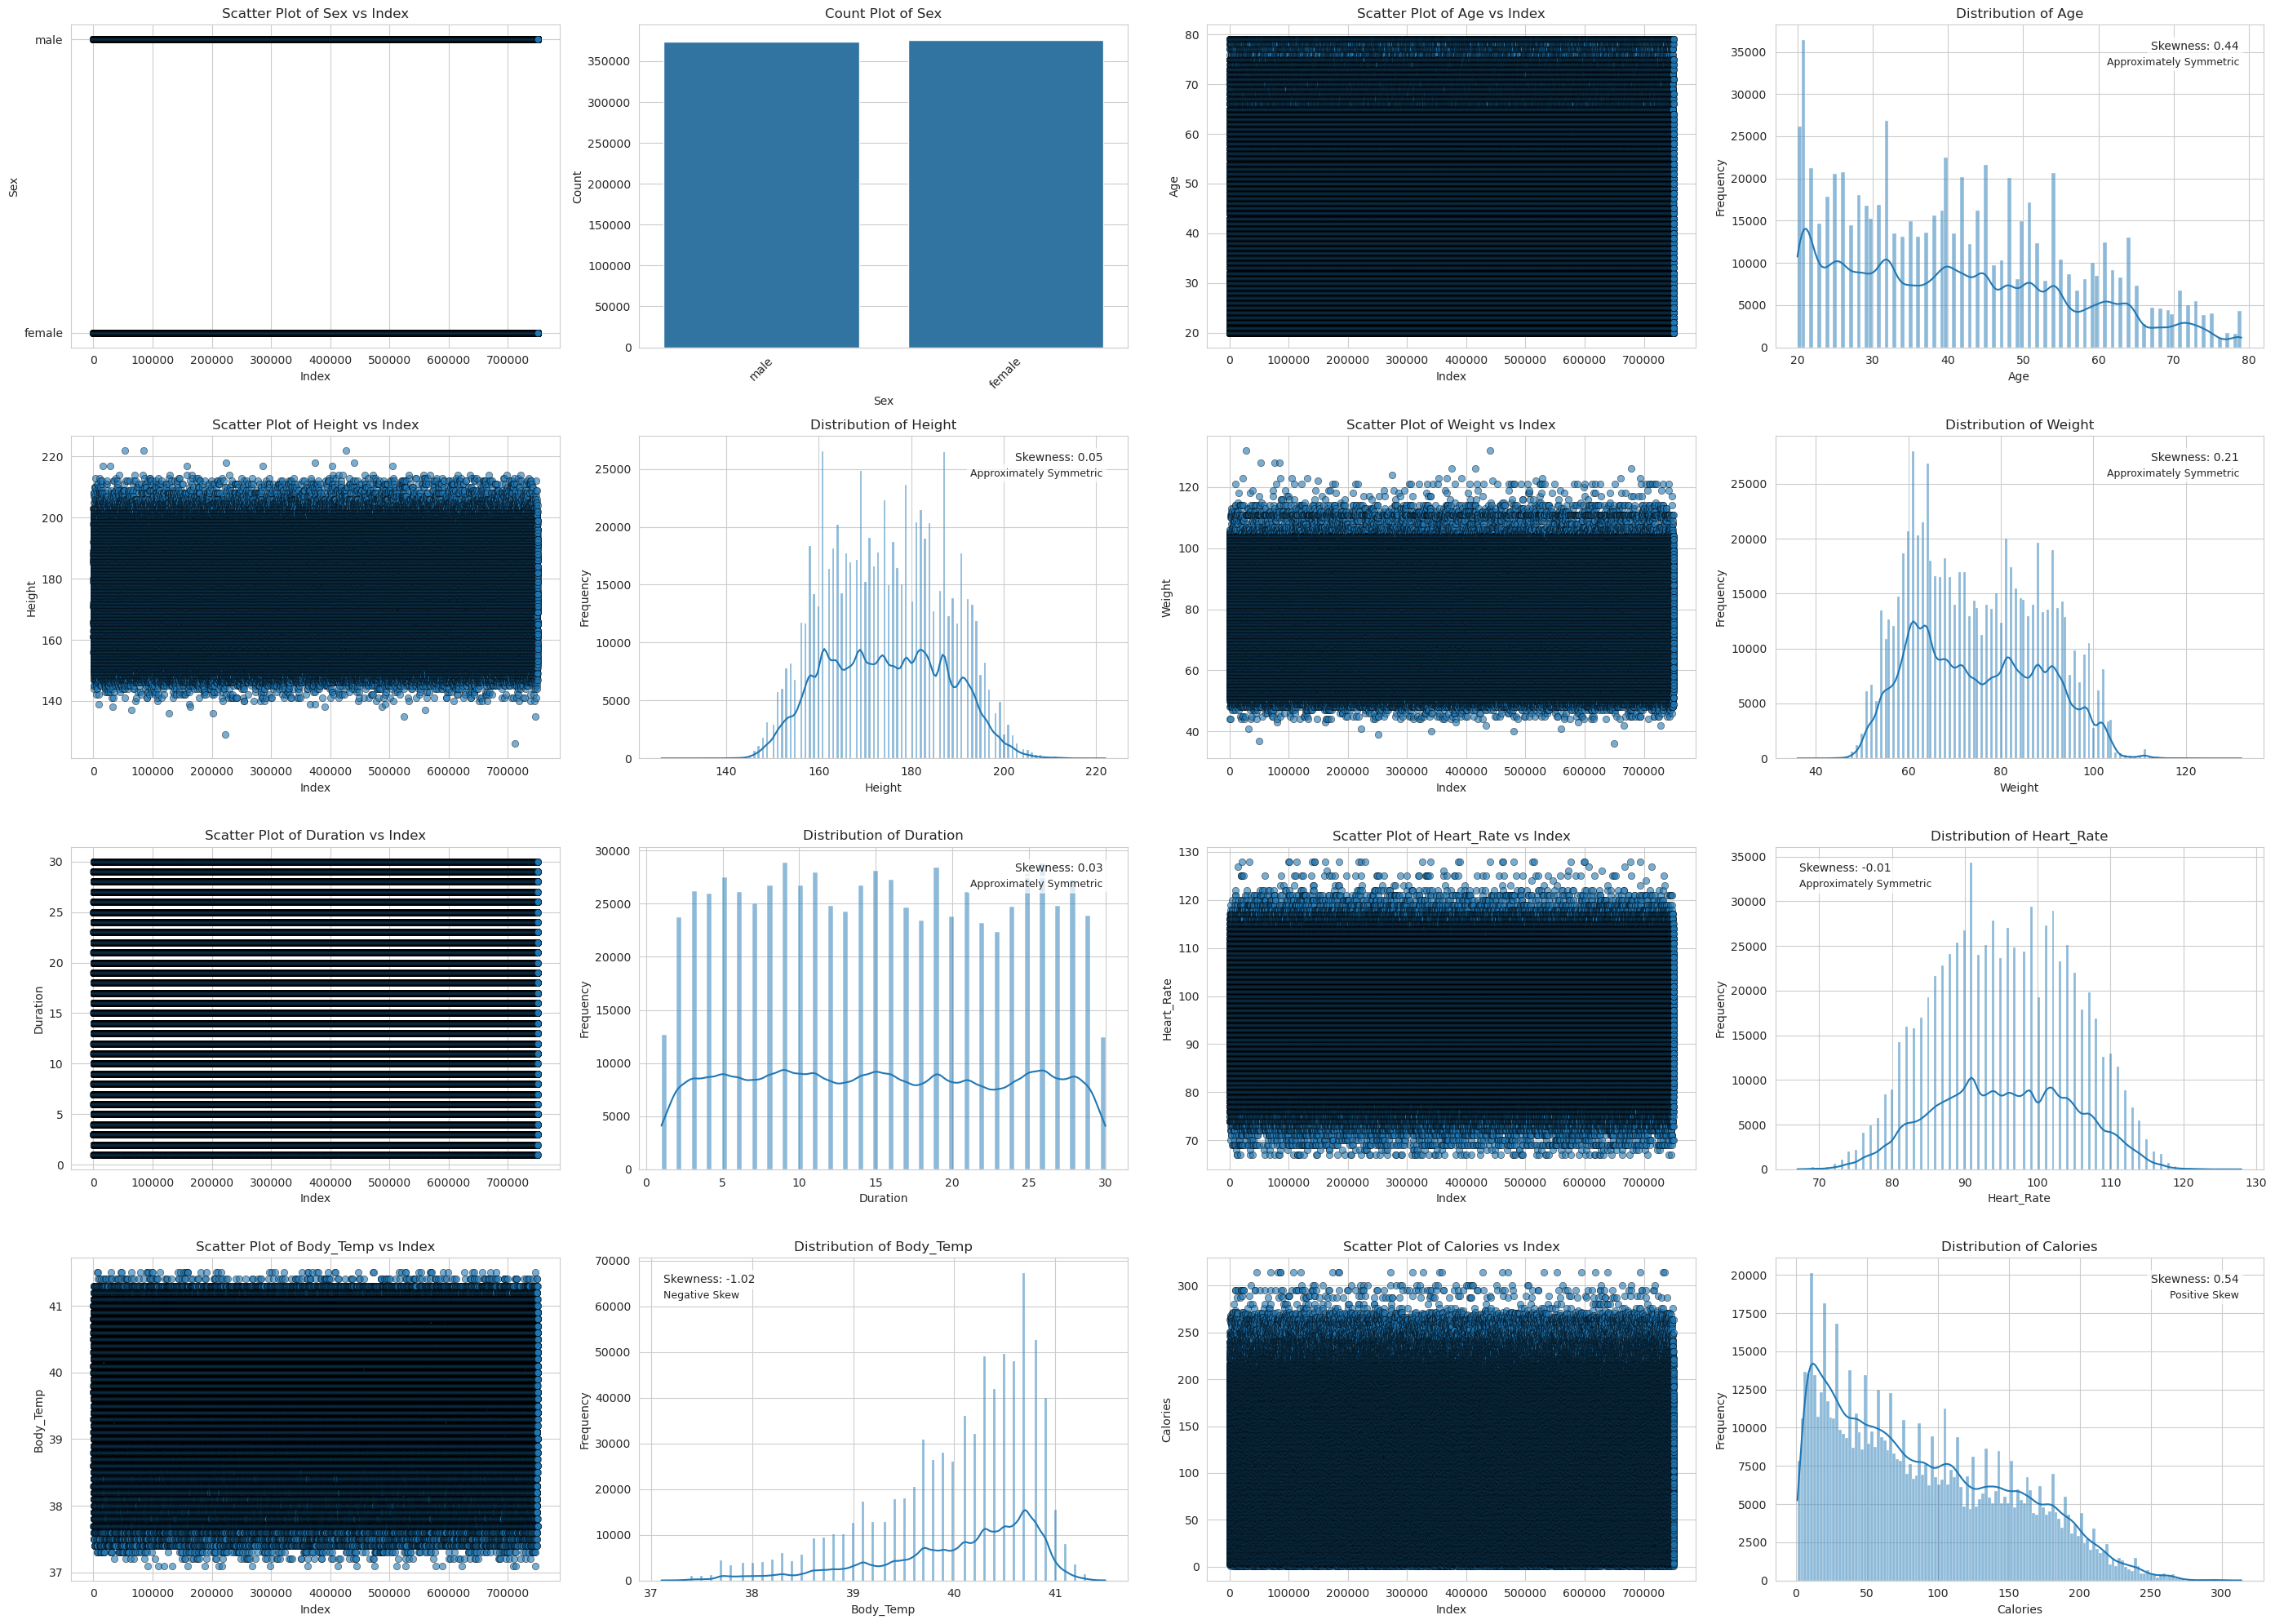

In [9]:

def create_scatter_distribution_plots(df, columns, n_cols=2):
    """
    Create scatter and distribution plots for specified columns side by side.

    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing the data
    columns : list
        List of column names to plot
    n_cols : int, default=2
        Number of columns in the plot grid
    """
    import seaborn as sns
    import matplotlib.pyplot as plt
    import scipy.stats as stats
    import numpy as np
    import math

    # Filter columns that exist in the dataframe
    plot_cols = df.columns[df.columns.isin(columns)]

    # Calculate number of rows needed based on n_cols
    n_rows = math.ceil(len(plot_cols) / (n_cols // 2))

    # Create figure with appropriate size
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(7*n_cols, 5*n_rows), squeeze=False)

    # Dictionary to store skewness values
    skewness_dict = {}

    for i, col in enumerate(plot_cols):
        # Calculate row and column positions
        row_idx = i // (n_cols // 2)
        col_idx = (i % (n_cols // 2)) * 2  # Multiply by 2 to leave space for distribution plot

        # Scatter plot in first column
        sns.scatterplot(data=df, x=df.index, y=col, edgecolor="0",alpha=0.6, ax=axes[row_idx, col_idx])
        axes[row_idx, col_idx].set_title(f'Scatter Plot of {col} vs Index')
        axes[row_idx, col_idx].set_xlabel('Index')
        axes[row_idx, col_idx].set_ylabel(col)

        # Distribution plot in second column
        # For categorical columns, use countplot
        if df[col].dtype == 'object' or df[col].dtype.name == 'category':
            sns.countplot(data=df, x=col, ax=axes[row_idx, col_idx+1])
            axes[row_idx, col_idx+1].set_title(f'Count Plot of {col}')
            axes[row_idx, col_idx+1].set_xlabel(col)
            axes[row_idx, col_idx+1].set_ylabel('Count')
            # Rotate x-axis labels if there are many categories
            axes[row_idx, col_idx+1].tick_params(axis='x', rotation=45)
        # For numeric columns, use histogram with KDE
        else:
            # Calculate skewness
            skewness = stats.skew(df[col].dropna())
            skewness_dict[col] = skewness

            # Plot histogram with KDE
            sns.histplot(data=df, x=col, kde=True, ax=axes[row_idx, col_idx+1])

            # Determine text position based on skewness value
            h_align = 'left' if skewness < 0 else 'right'
            x_pos = 0.05 if skewness < 0 else 0.95

            # Add skewness value to plot
            axes[row_idx, col_idx+1].text(
                x_pos, 0.95, f'Skewness: {skewness:.2f}',
                transform=axes[row_idx, col_idx+1].transAxes,
                fontsize=10,
                verticalalignment='top',
                horizontalalignment=h_align,
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.7)
            )

            axes[row_idx, col_idx+1].set_title(f'Distribution of {col}')
            axes[row_idx, col_idx+1].set_xlabel(col)
            axes[row_idx, col_idx+1].set_ylabel('Frequency')

            # Explain skewness direction
            if skewness > 0.5:
                skew_text = "Positive Skew"
            elif skewness < -0.5:
                skew_text = "Negative Skew"
            else:
                skew_text = "Approximately Symmetric"

            axes[row_idx, col_idx+1].text(
                x_pos, 0.90, skew_text,
                transform=axes[row_idx, col_idx+1].transAxes,
                fontsize=9,
                verticalalignment='top',
                horizontalalignment=h_align,
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.7)
            )

    # Hide unused subplots
    for i in range(len(plot_cols), n_rows * (n_cols // 2)):
        row_idx = i // (n_cols // 2)
        col_idx = (i % (n_cols // 2)) * 2
        axes[row_idx, col_idx].axis('off')
        axes[row_idx, col_idx+1].axis('off')

    plt.tight_layout()
    plt.show()

    # Return dictionary of skewness values for all numeric columns
    # return skewness_dict




columns =df.columns
create_scatter_distribution_plots(df, columns,n_cols=4)


## Feature engineering

BMI = weight (kg) / [height (m)]²

Duration * Heart_Rate: This can indicate the intensity of the exercise and may have a stronger relationship with calories.

Weight * Duration: Heavier people may burn more calories in the same amount of time.

Age * Duration: The effect of exercise duration on calories may change with age.

In [10]:
df['BMI'] = df['Weight'] / ( (df['Height']/100)**2 )
df['exercise_intensity'] = df['Duration'] * df['Heart_Rate']
df['WD'] = df['Weight'] * df['Duration']
df['AD'] = df['Age'] * df['Duration']

df.head(3)

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,BMI,exercise_intensity,WD,AD
0,male,36,189,82.0,26.0,101,41.0,150.0,22.955684,2626.0,2132.0,936.0
1,female,64,163,60.0,8.0,85,39.7,34.0,22.582709,680.0,480.0,512.0
2,female,51,161,64.0,7.0,84,39.8,29.0,24.690405,588.0,448.0,357.0


Investigating linear and nonlinear relationships between features

Number of selected columns: 11
Column names: ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp', 'Calories', 'BMI', 'exercise_intensity', 'WD', 'AD']


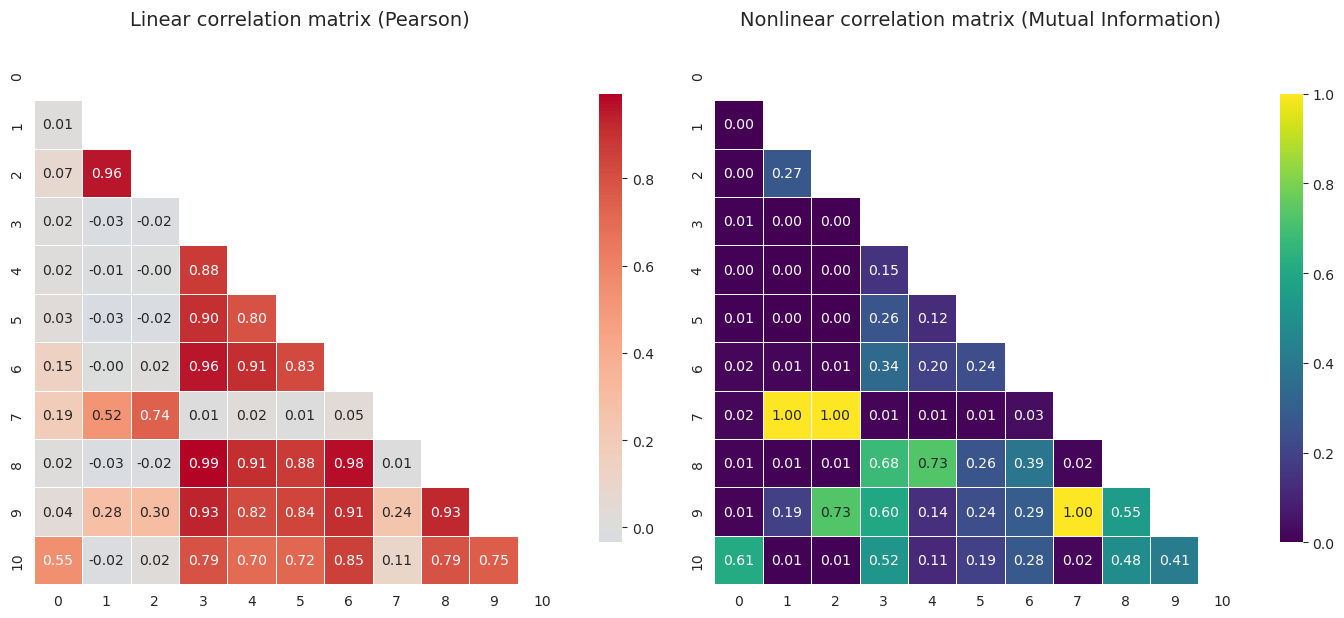


Pairs of strongly correlated features:

Strong linear correlation (|r| > 0.7):

  • Height ↔ Weight: 0.958
  • Weight ↔ BMI: 0.740
  • Duration ↔ Heart_Rate: 0.875
  • Duration ↔ Body_Temp: 0.903
  • Duration ↔ Calories: 0.960
  • Duration ↔ exercise_intensity: 0.994
  • Duration ↔ WD: 0.931
  • Duration ↔ AD: 0.792
  • Heart_Rate ↔ Body_Temp: 0.796
  • Heart_Rate ↔ Calories: 0.909
  • Heart_Rate ↔ exercise_intensity: 0.906
  • Heart_Rate ↔ WD: 0.819
  • Body_Temp ↔ Calories: 0.829
  • Body_Temp ↔ exercise_intensity: 0.877
  • Body_Temp ↔ WD: 0.841
  • Body_Temp ↔ AD: 0.719
  • Calories ↔ exercise_intensity: 0.977
  • Calories ↔ WD: 0.913
  • Calories ↔ AD: 0.855
  • exercise_intensity ↔ WD: 0.927
  • exercise_intensity ↔ AD: 0.790
  • WD ↔ AD: 0.755

 Strong nonlinear correlation (MI > 0.7):

  • Height ↔ BMI: 1.000
  • Weight ↔ BMI: 1.000
  • Weight ↔ WD: 0.729
  • Heart_Rate ↔ exercise_intensity: 0.726
  • BMI ↔ WD: 1.000

 Hidden nonlinear relationships (MI Strong but |r| Weak):



In [11]:
from sklearn.feature_selection import mutual_info_regression
from scipy.stats import pearsonr
from typing import List, Optional, Tuple



def plot_correlation_matrix(
    dataframe: pd.DataFrame,
    selected_columns: Optional[List[str]] = None,
    figsize: Tuple[int, int] = (12, 10),
    cmap_linear: str = "coolwarm",
    cmap_nonlinear: str = "viridis",) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Plotting linear and nonlinear correlation matrices for selected features from a dataframe

    Parameters:
    -----------
    dataframe : pd.DataFrame
        Input dataframe containing data
    selected_columns : List[str], optional
        List of column names you want to check.
        If None, all numeric columns are selected.
    figsize : Tuple[int, int]
        Chart size (width, height)
    cmap_linear : str
        Color map for linear correlation
    cmap_nonlinear : str
        Color map for nonlinear correlation

    Returns:
    --------
    Tuple[pd.DataFrame, pd.DataFrame]
        Linear correlation matrix and nonlinear correlation matrix
    """

    # Selecting numeric columns from a dataframe
    numeric_columns = dataframe.select_dtypes(include=[np.number]).columns.tolist()

    # If certain columns are selected, we filter them.
    if selected_columns:
        # Checking that the selected columns exist in the dataframe
        valid_columns = [col for col in selected_columns if col in dataframe.columns]

        # Check if selected columns are numeric
        valid_numeric_columns = [col for col in valid_columns if col in numeric_columns]

        if not valid_numeric_columns:
            raise ValueError("No valid numeric column selected!")

        columns_to_use = valid_numeric_columns
    else:
        columns_to_use = numeric_columns

    # Display information for selected columns
    print(f"Number of selected columns: {len(columns_to_use)}")
    print(f"Column names: {columns_to_use}")

    # Create a subset of data
    data_subset = dataframe[columns_to_use]

    # Calculating linear correlation (Pearson)
    linear_correlation = data_subset.corr(method="pearson")

    # Calculating Nonlinear Correlation Using Mutual Information
    n_features = len(columns_to_use)
    nonlinear_correlation = pd.DataFrame(
        np.zeros((n_features, n_features)),
        index=columns_to_use,
        columns=columns_to_use,
    )

    # Calculate Mutual Information for each pair of features
    for i, col1 in enumerate(columns_to_use):
        for j, col2 in enumerate(columns_to_use):
            if i == j:
                # The correlation of a feature with itself is equal to 1.
                nonlinear_correlation.loc[col1, col2] = 1.0
            else:
                # Calculate MI between two features
                mi_score = mutual_info_regression(
                    data_subset[[col1]].values,
                    data_subset[col2].values,
                    random_state=42,
                )
                # MI normalization (between 0 and 1)
                # We use entropy for normalization.
                max_mi = min(
                    _calculate_entropy(data_subset[col1]),
                    _calculate_entropy(data_subset[col2]),
                )
                if max_mi > 0:
                    normalized_mi = mi_score[0] / max_mi
                else:
                    normalized_mi = 0
                nonlinear_correlation.loc[col1, col2] = min(normalized_mi, 1.0)

    # Drawing diagrams
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    linear_mask = np.triu(np.ones_like(linear_correlation, dtype=bool))
    # Linear correlation chart
    sns.heatmap(
        linear_correlation,
        mask= linear_mask,
        annot=True,
        fmt=".2f",
        cmap=cmap_linear,
        center=0,
        square=True,
        linewidths=0.5,
        cbar_kws={"shrink": 0.8},
        ax=axes[0],
    )
    axes[0].set_title("Linear correlation matrix (Pearson)", fontsize=14, pad=20)
    axes[0].grid(False)

    nonlinear_mask = np.triu(np.ones_like(nonlinear_correlation, dtype=bool))
    # Nonlinear correlation diagram
    sns.heatmap(
        nonlinear_correlation,
        mask=nonlinear_mask,
        annot=True,
        fmt=".2f",
        cmap=cmap_nonlinear,
        vmin=0,
        vmax=1,
        square=True,
        linewidths=0.5,
        cbar_kws={"shrink": 0.8},
        ax=axes[1],
    )
    axes[1].set_title("Nonlinear correlation matrix (Mutual Information)", fontsize=14, pad=20)
    axes[1].grid(False)


    plt.tight_layout()
    plt.show()

    # Displaying features that have strong correlations
    _print_strong_correlations(linear_correlation, nonlinear_correlation)

    return linear_correlation, nonlinear_correlation


def _calculate_entropy(series: pd.Series) -> float:
    """Calculating the entropy of a data set for normalizationMI"""
    # Data discretization
    bins = min(int(np.sqrt(len(series))), 50)
    counts, _ = np.histogram(series, bins=bins)
    probabilities = counts / counts.sum()
    # Eliminate zero probabilities
    probabilities = probabilities[probabilities > 0]
    # Entropy calculation
    entropy = -np.sum(probabilities * np.log2(probabilities))
    return entropy


def _print_strong_correlations(
    linear_corr: pd.DataFrame, nonlinear_corr: pd.DataFrame, threshold: float = 0.7
) -> None:
    """Displaying pairs of features that are strongly correlated"""

    print("\n" + "=" * 60)
    print("Pairs of strongly correlated features:")
    print("=" * 60)

    # Finding strong linear correlations
    print("\nStrong linear correlation (|r| > {}):\n".format(threshold))
    for i in range(len(linear_corr.columns)):
        for j in range(i + 1, len(linear_corr.columns)):
            corr_value = linear_corr.iloc[i, j]
            if abs(corr_value) > threshold:
                print(
                    f"  • {linear_corr.columns[i]} ↔ {linear_corr.columns[j]}: "
                    f"{corr_value:.3f}"
                )

    # Finding Strong Nonlinear Correlations
    print(f"\n Strong nonlinear correlation (MI > {threshold}):\n")
    for i in range(len(nonlinear_corr.columns)):
        for j in range(i + 1, len(nonlinear_corr.columns)):
            mi_value = nonlinear_corr.iloc[i, j]
            if mi_value > threshold:
                print(
                    f"  • {nonlinear_corr.columns[i]} ↔ {nonlinear_corr.columns[j]}: "
                    f"{mi_value:.3f}"
                )

    # Finding nonlinear relationships that are not apparent in linear correlation
    print("\n Hidden nonlinear relationships (MI Strong but |r| Weak):\n")
    for i in range(len(linear_corr.columns)):
        for j in range(i + 1, len(linear_corr.columns)):
            linear_value = abs(linear_corr.iloc[i, j])
            nonlinear_value = nonlinear_corr.iloc[i, j]
            if nonlinear_value > 0.5 and linear_value < 0.3:
                print(
                    f"  • {linear_corr.columns[i]} ↔ {linear_corr.columns[j]}: "
                    f"MI={nonlinear_value:.3f}, |r|={linear_value:.3f}"
                )



linear_corr, nonlinear_corr = plot_correlation_matrix(dataframe=df , selected_columns=None , figsize=(14,6))

## Selecting features
Choosing the importance of features using the combination of RandomForestRegressor + permutation_importance

In [12]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler



# Creating X and Y
X = df.drop(columns=['Calories'], axis=1)
Y = df['Calories'].values.ravel()

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0, shuffle=True)

categorical_cols = ['Sex']
numerical_cols = ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp',
                  'BMI', 'exercise_intensity', 'WD', 'AD']




# Creating mappings for categorical columns
label_mapping = {}
for col in categorical_cols:
    unique_values = sorted(X[col].unique())
    label_mapping[col] = {val: idx for idx, val in enumerate(unique_values)}

# Create a list of categories for OrdinalEncoder
categories_list = []
for col in categorical_cols:
    mapping = label_mapping[col]
    categories = [k for k, v in sorted(mapping.items(), key=lambda item: item[1])]
    categories_list.append(categories)

# Saving the label mapping as a CSV file
mapping_df_list = []

for i, mapping in label_mapping.items():
    temp_df = pd.DataFrame(list(mapping.items()), columns=['Original_Value', 'Encoded_Value'])
    temp_df['column_Name'] = i
    mapping_df_list.append(temp_df)

final_mapping_df = pd.concat(mapping_df_list)
csv_mapping_file_path = 'label_mapping.csv'
final_mapping_df.to_csv(csv_mapping_file_path, index=False)

print(csv_mapping_file_path)
print(label_mapping)




preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(categories=categories_list), categorical_cols),
        ('num', MinMaxScaler(), numerical_cols)
    ],
    remainder='drop',
    verbose_feature_names_out=False
)

model = RandomForestRegressor(n_estimators=100)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])
pipeline.fit(X_train, Y_train)



result = permutation_importance(
    estimator=pipeline,
    X=X_test, y=Y_test,
    n_repeats=10,
    random_state=42
)

feature_names_processed = pipeline.named_steps['preprocessor'].get_feature_names_out()
importances_perm = result.importances_mean



feat_imp = pd.Series(importances_perm, index=feature_names_processed)
feat_imp_sorted = feat_imp.sort_values(ascending=False)

print("Feature importances (sorted):")
print(feat_imp_sorted)



label_mapping.csv
{'Sex': {'female': 0, 'male': 1}}
Feature importances (sorted):
exercise_intensity    0.254091
Heart_Rate            0.108677
Duration              0.059943
AD                    0.022105
Age                   0.009009
WD                    0.003713
Weight                0.003049
Body_Temp             0.001025
BMI                   0.000379
Height                0.000303
Sex                   0.000037
dtype: float64


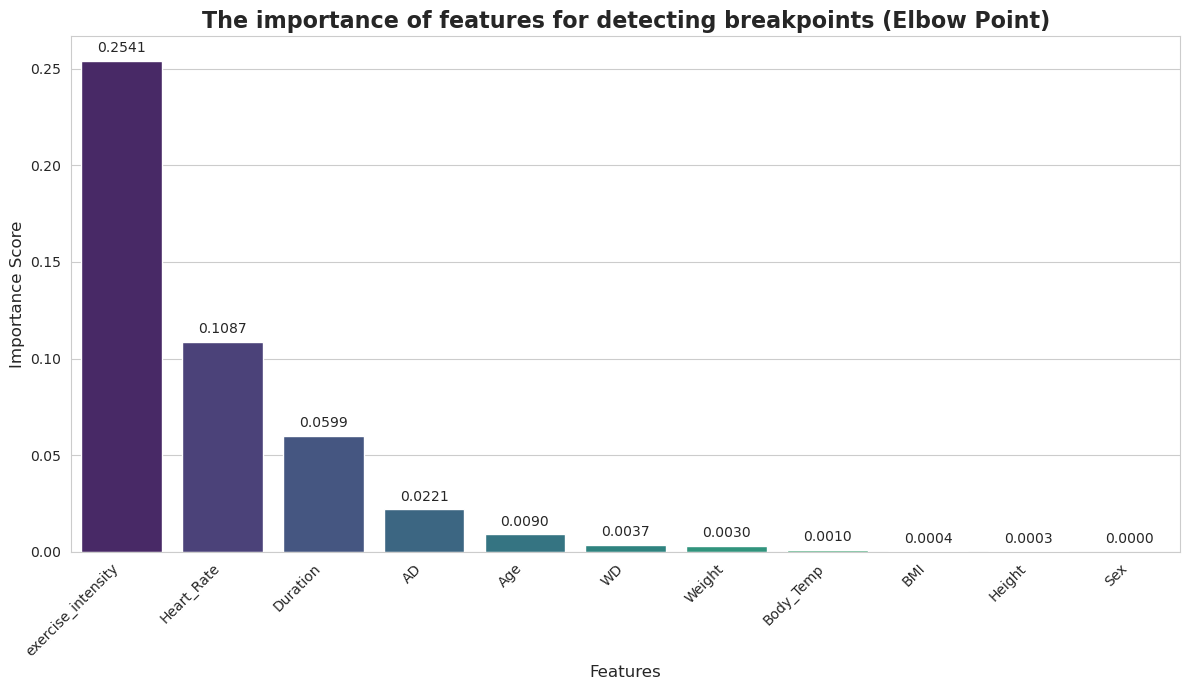

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.figure(figsize=(12, 7))

barplot = sns.barplot(x=feat_imp_sorted.index, y=feat_imp_sorted.values, palette="viridis")

plt.title('The importance of features for detecting breakpoints (Elbow Point)', fontsize=16, weight='bold')
plt.xlabel('Features', fontsize=12)
plt.ylabel('Importance Score', fontsize=12)

plt.xticks(rotation=45, ha='right')

for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.4f'),
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha = 'center', va = 'center',
                     xytext = (0, 9),
                     textcoords = 'offset points')

plt.tight_layout()

plt.show()

## Creating the initial model
We build our model with selected features and perform all steps in a pipeline.

In [14]:
from sklearn.base import BaseEstimator, TransformerMixin
import xgboost as xgb

# This class contains all the logic for creating new features.
class FeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        # In this particular case, the fit step does nothing
        return self

    def transform(self, X, y=None):
        # We create a copy of the dataframe so that the original is not changed.
        X_transformed = X.copy()

        # Creating new features based on formulas
        # Note: We make sure that the calculations are performed correctly even on the test data
        X_transformed['BMI'] = X_transformed['Weight'] / ((X_transformed['Height'] / 100) ** 2)
        X_transformed['exercise_intensity'] = X_transformed['Duration'] * X_transformed['Heart_Rate']
        X_transformed['WD'] = X_transformed['Weight'] * X_transformed['Duration']
        X_transformed['AD'] = X_transformed['Age'] * X_transformed['Duration']

        return X_transformed



final_model_features = [
    'exercise_intensity',
    'Heart_Rate',
    'Duration',
    'AD',
    'Age'
]

# Building a final preprocessor that only works on selected features
# Since all your selected features are numeric, we no longer need OrdinalEncoder.
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', MinMaxScaler(), final_model_features)
    ],
    remainder='drop' # Very important: Delete the rest of the columns (original and created)
)



model = xgb.XGBRegressor(n_estimators=100)
# Building a complete and final pipeline
pipeline = Pipeline(steps=[
    # Step 1: Create custom features
    ('feature_engineering', FeatureEngineer()),

    # Step 2: Select, scale the final features and remove the rest
    ('preprocessing', preprocessor),

    # Step 3: Final Model
    ('model', model)
])



# Creating X and Y on oroginal_df
X = original_df.drop(columns=['Calories'], axis=1)
Y = original_df['Calories'].values.ravel()

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0, shuffle=True)

# Full pipeline training with train data only
pipeline.fit(X_train, Y_train)


train_score = pipeline.score(X_train, Y_train)
test_score = pipeline.score(X_test, Y_test)

print(f"Accuracy of the base model on Training data: {train_score:.4f}")
print(f"Accuracy of the base model on Test data: {test_score:.4f}")


Accuracy of the base model on Training data: 0.9894
Accuracy of the base model on Test data: 0.9889


## Model optimization
We use the optuna library with cross validation to optimize the parameters.

In [15]:
import optuna
from xgboost.callback import EarlyStopping
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import r2_score, root_mean_squared_error
from sklearn.metrics import mean_squared_log_error

# --- Objective function definition for Optuna ---

import xgboost as xgb
from xgboost.callback import EarlyStopping

def objective(trial):
    """
    Objective function using the original XGBoost API and DMatrix to properly implement Early Stopping.
    """
    #  Defining the search space for hyperparameters
    # n_estimators is removed from here and used as num_boost_round
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'lambda': trial.suggest_float('lambda', 1e-2, 10.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-2, 10.0, log=True),
        'verbosity': 0,
        'device': 'cuda',

    }
    # Let n_estimators be the number of training rounds (boosting rounds)
    num_boost_round = trial.suggest_int('n_estimators', 100, 2000)

   # Manual Cross-Validation Loop
    cv = KFold(n_splits=10, shuffle=True, random_state=42)
    scores = []

    for train_idx, val_idx in cv.split(X_train, Y_train):
        # Separate the data from this fold
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        Y_train_fold, Y_val_fold = Y_train[train_idx], Y_train[val_idx]

       # Using pipelines only for data preprocessing
        preprocessor = ColumnTransformer([('scaler', MinMaxScaler(), final_model_features)], remainder='drop')
        transformers_pipeline = Pipeline([('feature_engineering', FeatureEngineer()), ('preprocessing', preprocessor)])

        X_train_fold_processed = transformers_pipeline.fit_transform(X_train_fold)
        X_val_fold_processed = transformers_pipeline.transform(X_val_fold)

        # Convert data to DMatrix format for XGBoost
        dtrain = xgb.DMatrix(X_train_fold_processed, label=Y_train_fold)
        dvalid = xgb.DMatrix(X_val_fold_processed, label=Y_val_fold)

        # The EarlyStopping number works for each fold.
        early_stop = xgb.callback.EarlyStopping(
            rounds=4,           # The number of waiting rounds is smaller than the number of folds
            metric_name='rmse',  # Metric to monitor
            data_name='Valid',
            maximize=False
        )

        # Training the model with xgb.train
        booster = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=num_boost_round,
            evals=[(dtrain, 'Train'), (dvalid, 'Valid')],
            callbacks=[early_stop],
            verbose_eval=False
        )

        # We store the best score (RMSE) in this fold
        # booster.best_score automatically returns the best score from eval_set
        scores.append(booster.best_score)

    # Return the average score of the best performance across all folds
    return np.mean(scores)




print("--- Start hyperparameter optimization with Optuna ---")
study = optuna.create_study(direction='minimize') # Objective: Minimize RMSE
study.optimize(objective, n_trials=10, show_progress_bar=True)

# Get the best parameters
best_params = study.best_params
print("\n* Optimization completed..")
print(f"Best RMSE value in CV (training data): {study.best_value:.4f}")
print("Best hyperparameters found:", best_params)


# ---  Training and evaluating the final model with the best parameters ---
print("\n--- Training the final model with the best parameters and evaluating it on the test data ---")

# Build the final pipeline with the best parameters
final_preprocessor = ColumnTransformer(
    transformers=[('scaler', MinMaxScaler(), final_model_features)],
    remainder='drop'
)

final_pipeline = Pipeline(steps=[
    ('feature_engineering', FeatureEngineer()),
    ('preprocessing', final_preprocessor),
    ('model', xgb.XGBRegressor(**best_params, random_state=42))
])

# Training on the entire training data
final_pipeline.fit(X_train, Y_train)

# Prediction on test data
Y_pred_test = final_pipeline.predict(X_test)

# Calculating final metrics on test data
final_rmse = root_mean_squared_error(Y_test, Y_pred_test)
final_r2 = r2_score(Y_test, Y_pred_test)
final_rmsle = np.sqrt(mean_squared_log_error(Y_test, Y_pred_test))

print(f"\n Performance of the optimized model on the final test data:")
print(f" Final RMSE: {final_rmse:.4f}")
print(f" Final R-squared: {final_r2:.4f}")
print(f" Final RMSLE : {final_rmsle:.4f}")

[I 2025-07-24 01:07:18,209] A new study created in memory with name: no-name-00efd307-ed78-4d45-80d2-46f0ee57b934


--- Start hyperparameter optimization with Optuna ---


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-07-24 01:07:31,605] Trial 0 finished with value: 6.623666888400841 and parameters: {'learning_rate': 0.09743085064500169, 'max_depth': 6, 'subsample': 0.7241774005578292, 'colsample_bytree': 0.7116180508645078, 'lambda': 2.9074112517283672, 'alpha': 7.820165601927491, 'n_estimators': 1855}. Best is trial 0 with value: 6.623666888400841.
[I 2025-07-24 01:07:45,004] Trial 1 finished with value: 6.6083404229722245 and parameters: {'learning_rate': 0.07748334335368232, 'max_depth': 7, 'subsample': 0.6166346318047362, 'colsample_bytree': 0.7234997258959973, 'lambda': 0.021557577595519347, 'alpha': 4.716213539295208, 'n_estimators': 250}. Best is trial 1 with value: 6.6083404229722245.
[I 2025-07-24 01:08:07,787] Trial 2 finished with value: 6.583671410657599 and parameters: {'learning_rate': 0.04446353976400755, 'max_depth': 9, 'subsample': 0.7805471865824424, 'colsample_bytree': 0.9847972162633473, 'lambda': 1.0885558303844975, 'alpha': 3.8661437356439508, 'n_estimators': 1294}. Be

## Test pipeline on sample data

In [16]:

new_data_dict = {
    'id' : [4],
    'Sex': ['female'],
    'Age': [38],
    'Height': [166],
    'Weight': [61],
    'Duration': [25],
    'Heart_Rate': [102],
    'Body_Temp': [40.6]
}

new_data_df = pd.DataFrame(new_data_dict)
predicted_calories = final_pipeline.predict(new_data_df)

print(f"Estimated calories:{predicted_calories[0]:.2f}")

Estimated calories:146.60


## Saving the optimal model with the pipeline

In [17]:
import joblib


final_preprocessor = ColumnTransformer(
    transformers=[('scaler', MinMaxScaler(), final_model_features)],
    remainder='drop'
)

print('Optimal parameters:',best_params)

final_pipeline = Pipeline(steps=[
    ('feature_engineering', FeatureEngineer()),
    ('preprocessing', final_preprocessor),
    ('model', xgb.XGBRegressor(**best_params,random_state=42))
])

# Training the final pipeline on the entire data
final_pipeline.fit(X, Y)


# Save the entire pipeline object to a file
filename = 'calorie_prediction_pipeline.joblib'
joblib.dump(final_pipeline, filename)

print(f"\n Successfully pipelined Saved to file '{filename}'.")

Optimal parameters: {'learning_rate': 0.017759891438291417, 'max_depth': 9, 'subsample': 0.9117363936231678, 'colsample_bytree': 0.6462287213796112, 'lambda': 0.15867521663286743, 'alpha': 3.078974908623239, 'n_estimators': 1754}

 Successfully pipelined Saved to file 'calorie_prediction_pipeline.joblib'.


In [18]:
# load to test
filename = 'calorie_prediction_pipeline.joblib'
loaded_pipeline = joblib.load(filename)

new_unseen_data = pd.read_csv('test.csv')
new_unseen_data = pd.DataFrame(new_unseen_data)

predicted_calories = loaded_pipeline.predict(new_unseen_data)


# Save the dataframe to a CSV file
start_id = 750000
num_predictions = len(predicted_calories)
id_column = np.arange(start_id, start_id + num_predictions)

results_df = pd.DataFrame({
    'id': id_column,
    'Calories': predicted_calories
})


output_filename = 'predicted_calories.csv'
results_df.to_csv(output_filename, index=False)

results_df

,id,Calories
0,750000,29.087793
1,750001,107.763550
2,750002,88.130081
3,750003,131.980698
4,750004,72.481544
...,...,...
249995,999995,25.462379
249996,999996,9.782226
249997,999997,70.384026
249998,999998,184.433456
